In [1]:
from Data_manager.UserUtils import *
from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
import numpy as np
URM_all = getURM_all()
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
#URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.80)

In [2]:
# SETUP EVALUATORS
from Evaluation.Evaluator import EvaluatorHoldout

#evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2114 (16.7%) Users that have less than 1 test interactions


In [3]:
import numpy as np 
import scipy.sparse as sps
profile_length = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)

#profile_length = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)
profile_length, profile_length.shape

(array([33, 33,  4, ...,  7, 20, 46], dtype=int32), (12638,))

In [4]:
block_size = int(len(profile_length)*0.1)
block_size

1263

In [9]:
sorted_users = np.argsort(profile_length)
for group_id in range(0, 10):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 1263, average p.len 0.84, median 1.0, min 0, max 2
Group 1, #users in group 1263, average p.len 2.43, median 2.0, min 2, max 3
Group 2, #users in group 1263, average p.len 4.69, median 5.0, min 3, max 6
Group 3, #users in group 1263, average p.len 7.67, median 8.0, min 6, max 10
Group 4, #users in group 1263, average p.len 11.91, median 12.0, min 10, max 14
Group 5, #users in group 1263, average p.len 17.59, median 17.0, min 14, max 21
Group 6, #users in group 1263, average p.len 25.73, median 25.0, min 21, max 31
Group 7, #users in group 1263, average p.len 37.66, median 37.0, min 31, max 46
Group 8, #users in group 1263, average p.len 58.67, median 57.0, min 46, max 76
Group 9, #users in group 1263, average p.len 132.08, median 110.0, min 76, max 491


In [5]:
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Hybrid import *
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.FactorizationMachines.LightFMRecommender import LightFMCFRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import *
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3_old": RP3betaRecommender,
                                   "RP3": RP3betaRecommender,
                                   "SLIM_ELASTIC": SLIMElasticNetRecommender,
                                   "MULTVAE": MultVAERecommender,
                                   "EASE_R": EASE_R_Recommender,
                                   }
collaborative_recommender_class.items()

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train_validation)
    recommender_object_dict[label] = recommender_object
    
    
recommender_object_dict["TopPop"].fit()
recommender_object_dict["SLIM_ELASTIC"].fit(topK=8894, l1_ratio=0.05565733019999427, alpha=0.0012979360257937668)#, workers=7)
#recommender_object_dict["PureSVD"].fit(num_factors=70, random_seed=42)
recommender_object_dict["P3alpha"].fit(topK=76, alpha=0.377201600381895, normalize_similarity=True)
recommender_object_dict["RP3_old"].fit(topK=101, alpha=0.3026342852596128, beta=0.058468783118329024)
recommender_object_dict["RP3"].fit(alpha=0.20026352123406477, beta=0.15999879728761354, topK=32)
recommender_object_dict["UserKNNCF"].fit(topK=469, shrink=38, similarity='asymmetric', normalize=True,
                                       feature_weighting='TF-IDF', asymmetric_alpha=0.40077406933762383)
recommender_object_dict["ItemKNNCF"].fit(topK=31, shrink=435, similarity='tversky', normalize=True,
                                       feature_weighting='BM25', tversky_alpha=0.17113169506422393, tversky_beta=0.5684024974085575)
#recommender_object_dict["SLIM2"].fit(topK=700, l1_ratio=0.015024, alpha=0.001970400636566181, workers=7)
recommender_object_dict["EASE_R"].fit(topK=24, l2_norm=37.54323189430143)
recommender_object_dict["MULTVAE"].fit(epochs=120, learning_rate=0.0003386225308766206, l2_reg=2.129359930047709e-06, dropout=0.09838599885053126, total_anneal_steps=525579, anneal_cap=0.4033304347929101,batch_size=256)
#recommender_object_dict["MF_BPR"].fit(sgd_mode="adagrad", num_factors=219, batch_size=32, learning_rate=0.08036400470449359,positive_reg=0.016211221706684466,negative_reg=0.00012672106970228173, epochs=260, random_seed=1234)
#recommender_object_dict["SLIM_BPR"].fit(topK=46, symmetric=True, sgd_mode="adagrad", epochs=195, lambda_i=0.00035732097169170193, lambda_j=0.004542391418975173, learning_rate=0.0002291767622519941)
#recommender_object_dict["LightFM"].load_model("result_experiments/", "LightFMCFRecommender_best_model.zip")
#recommender_object_dict["IALS"].fit()

/Users/alessandro/RecSys-2023-polimi/venv/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


TopPopRecommender: URM Detected 231 ( 1.8%) users with no interactions.
TopPopRecommender: URM Detected 114 ( 0.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 231 ( 1.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 114 ( 0.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 114 ( 0.5%) items with no interactions.
P3alphaRecommender: URM Detected 231 ( 1.8%) users with no interactions.
P3alphaRecommender: URM Detected 114 ( 0.5%) items with no interactions.
RP3betaRecommender: URM Detected 231 ( 1.8%) users with no interactions.
RP3betaRecommender: URM Detected 114 ( 0.5%) items with no interactions.
RP3betaRecommender: URM Detected 231 ( 1.8%) users with no interactions.
RP3betaRecommender: URM Detected 114 ( 0.5%) items with no interactions.
SLIMElasticNetRecommender: URM Detected 231 ( 1.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detecte

2023-12-21 18:05:57.767302: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-21 18:05:57.768029: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-21 18:05:57.768053: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-21 18:05:57.768579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-21 18:05:57.768983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-21 18:05:57.998789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-21 18:05:58.014719: I tensorflow/core/gra

MultVAERecommender: Saving model in file './result_experiments/__Temp_MultVAERecommender_78413/_best_model'
MultVAERecommender: Saving complete
MultVAERecommender: Epoch 1 of 120. Elapsed time 14.31 sec
MultVAERecommender: Epoch 2 of 120. Elapsed time 22.53 sec
MultVAERecommender: Epoch 3 of 120. Elapsed time 30.80 sec
MultVAERecommender: Epoch 4 of 120. Elapsed time 38.97 sec
MultVAERecommender: Epoch 5 of 120. Elapsed time 47.15 sec
MultVAERecommender: Epoch 6 of 120. Elapsed time 55.35 sec
MultVAERecommender: Epoch 7 of 120. Elapsed time 1.06 min
MultVAERecommender: Epoch 8 of 120. Elapsed time 1.20 min
MultVAERecommender: Epoch 9 of 120. Elapsed time 1.33 min
MultVAERecommender: Epoch 10 of 120. Elapsed time 1.47 min
MultVAERecommender: Epoch 11 of 120. Elapsed time 1.61 min
MultVAERecommender: Epoch 12 of 120. Elapsed time 1.74 min
MultVAERecommender: Epoch 13 of 120. Elapsed time 1.88 min
MultVAERecommender: Epoch 14 of 120. Elapsed time 2.02 min
MultVAERecommender: Epoch 15 of 1

2023-12-21 18:22:40.856013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-21 18:22:40.856037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


INFO:tensorflow:Restoring parameters from ./result_experiments/__Temp_MultVAERecommender_78413/_best_model/.session/session
MultVAERecommender: Loading complete
MultVAERecommender: Cleaning temporary files from './result_experiments/__Temp_MultVAERecommender_78413/'


In [7]:
from Hybrid import *


recommender_object_dict["hybrid"] = ScoresHybridRecommender(URM_train_validation, recommender_object_dict["SLIM_ELASTIC"], recommender_object_dict["RP3"], recommender_object_dict["ItemKNNCF"])
recommender_object_dict["hybrid"].fit(alpha=0.5072513954300486, beta=0.30902582824263064)

ScoresHybridRecommender: URM Detected 231 ( 1.8%) users with no interactions.
ScoresHybridRecommender: URM Detected 114 ( 0.5%) items with no interactions.


In [6]:
recommender_object_dict["hybrid_new"] = LinearHybridRecommender(URM_train_validation, [recommender_object_dict["SLIM_ELASTIC"], recommender_object_dict["RP3"], recommender_object_dict["ItemKNNCF"], recommender_object_dict["EASE_R"]])
recommender_object_dict["hybrid_new"].fit(alphas=[0.8857667100747117, 0.6379807942443021, 0.0690929184825888, 0.11953478623354052])

SLIMElasticNetRP3betaItemKNNCFEASE_R_HybridRecommender: URM Detected 231 ( 1.8%) users with no interactions.
SLIMElasticNetRP3betaItemKNNCFEASE_R_HybridRecommender: URM Detected 114 ( 0.5%) items with no interactions.


In [30]:
recommender_object_dict["superH"] = LinearHybridRecommender(URM_train_validation, [recommender_object_dict["SLIM_ELASTIC"], recommender_object_dict["RP3"], recommender_object_dict["KNN_H"], recommender_object_dict["EASE_R"]])
recommender_object_dict["superH"].fit(alphas=[0.8857667100747117, 0.6379807942443021, 0.0690929184825888, 0.11953478623354052])

SLIMElasticNetRP3betaTwoScoresHybridEASE_R_HybridRecommender: URM Detected 231 ( 1.8%) users with no interactions.
SLIMElasticNetRP3betaTwoScoresHybridEASE_R_HybridRecommender: URM Detected 114 ( 0.5%) items with no interactions.


In [45]:
recommender_object_dict["superH2"] = LinearHybridRecommender(URM_train_validation, [recommender_object_dict["SLIM_ELASTIC"], recommender_object_dict["RP3"], recommender_object_dict["KNN_H2"], recommender_object_dict["EASE_R"]])
recommender_object_dict["superH2"].fit(alphas=[0.8857667100747117, 0.6379807942443021, 0.0690929184825888, 0.11953478623354052])

SLIMElasticNetRP3betaTwoScoresHybridEASE_R_HybridRecommender: URM Detected 231 ( 1.8%) users with no interactions.
SLIMElasticNetRP3betaTwoScoresHybridEASE_R_HybridRecommender: URM Detected 114 ( 0.5%) items with no interactions.


In [24]:
recommender_object_dict["KNN_H"] = TwoScoresHybridRecommender(URM_train_validation, recommender_object_dict["UserKNNCF"], recommender_object_dict["ItemKNNCF"])
recommender_object_dict["KNN_H"].fit(alpha=0.022195783788315104)

TwoScoresHybridRecommender: URM Detected 231 ( 1.8%) users with no interactions.
TwoScoresHybridRecommender: URM Detected 114 ( 0.5%) items with no interactions.


In [41]:
recommender_object_dict["KNN_H2"] = TwoScoresHybridRecommender(URM_train_validation, recommender_object_dict["UserKNNCF"], recommender_object_dict["ItemKNNCF"])
recommender_object_dict["KNN_H2"].fit(alpha=0.01354362641773832)

TwoScoresHybridRecommender: URM Detected 231 ( 1.8%) users with no interactions.
TwoScoresHybridRecommender: URM Detected 114 ( 0.5%) items with no interactions.


In [50]:
userknn = UserKNNCFRecommender(URM_train_validation)
userknn.fit(topK=8712, shrink=916, similarity='cosine', normalize=True,
                                       feature_weighting='none')
itemknn = ItemKNNCFRecommender(URM_train_validation)
itemknn.fit(topK=5, shrink=356, similarity='asymmetric', normalize=True,
                                       feature_weighting='TF-IDF')

recommender_object_dict["KNN_H3"] = TwoScoresHybridRecommender(URM_train_validation, userknn, itemknn)
recommender_object_dict["KNN_H3"].fit(alpha=0.7118833472870402)

UserKNNCFRecommender: URM Detected 231 ( 1.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 114 ( 0.5%) items with no interactions.
Similarity column 12638 (100.0%), 11642.42 column/sec. Elapsed time 1.09 sec
ItemKNNCFRecommender: URM Detected 231 ( 1.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 114 ( 0.5%) items with no interactions.
Similarity column 22222 (100.0%), 9974.91 column/sec. Elapsed time 2.23 sec
TwoScoresHybridRecommender: URM Detected 231 ( 1.8%) users with no interactions.
TwoScoresHybridRecommender: URM Detected 114 ( 0.5%) items with no interactions.


In [10]:
# EQUAL SIZE GROUPING
from Evaluation.Evaluator import EvaluatorHoldout

MAP_recommender_per_group = {}
cutoff = 10

for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]


Group 0, #users in group 1263, average p.len 0.84, median 1.0, min 0, max 2
EvaluatorHoldout: Ignoring 2114 (16.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 11375 Users
EvaluatorHoldout: Processed 507 (100.0%) in 0.23 sec. Users per second: 2177
EvaluatorHoldout: Processed 507 (100.0%) in 0.29 sec. Users per second: 1726
EvaluatorHoldout: Processed 507 (100.0%) in 0.22 sec. Users per second: 2266
EvaluatorHoldout: Processed 507 (100.0%) in 0.21 sec. Users per second: 2389
EvaluatorHoldout: Processed 507 (100.0%) in 0.21 sec. Users per second: 2403
EvaluatorHoldout: Processed 507 (100.0%) in 0.21 sec. Users per second: 2459
EvaluatorHoldout: Processed 507 (100.0%) in 0.23 sec. Users per second: 2240
EvaluatorHoldout: Processed 507 (100.0%) in 1.26 sec. Users per second: 402
EvaluatorHoldout: Processed 507 (100.0%) in 0.21 sec. Users per second: 2400
EvaluatorHoldout: Processed 507 (100.0%) in 0.23 sec. Users per second: 2237
EvaluatorHoldout: Processed 50

In [51]:
# PROFILE LENGTH BASED GROUPING
from Evaluation.Evaluator import EvaluatorHoldout
import numpy as np

MAP_recommender_per_group = {}
cutoff = 10
profile_length_cutoffs = [2, 3, 6, 10, 14, 21, 31, 46, 75, 1500]
# Define the cutoffs for profile length for each group
#profile_length_cutoffs = [2, 3, 4, 6, 8, 25, 80, 100, 250, 1500]

for group_id in range(len(profile_length_cutoffs)):

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if group_id == 0:
        users_in_group_flag = profile_length < profile_length_cutoffs[group_id]
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[group_id - 1],
                                             profile_length < profile_length_cutoffs[group_id])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]

    if len(users_in_group) > 0:
        users_in_group_p_len = profile_length[users_in_group]

        print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
            group_id,
            users_in_group.shape[0],
            users_in_group_p_len.mean(),
            np.median(users_in_group_p_len),
            users_in_group_p_len.min(),
            users_in_group_p_len.max()))

        # Select users not in the current group
        users_not_in_group_flag = np.isin(np.arange(len(profile_length)), users_in_group, invert=True)
        users_not_in_group = np.arange(len(profile_length))[users_not_in_group_flag]

        evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

        for label, recommender in recommender_object_dict.items():
            result_df, _ = evaluator_test.evaluateRecommender(recommender)
            if label in MAP_recommender_per_group:
                MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
            else:
                MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
    else:
        print(f"Group {group_id} has no users.")

Group 0, #users in group 1239, average p.len 0.81, median 1.0, min 0, max 1
EvaluatorHoldout: Ignoring 2114 (16.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 11399 Users
EvaluatorHoldout: Processed 497 (100.0%) in 0.24 sec. Users per second: 2085
EvaluatorHoldout: Processed 497 (100.0%) in 0.29 sec. Users per second: 1717
EvaluatorHoldout: Processed 497 (100.0%) in 0.22 sec. Users per second: 2288
EvaluatorHoldout: Processed 497 (100.0%) in 0.21 sec. Users per second: 2321
EvaluatorHoldout: Processed 497 (100.0%) in 0.22 sec. Users per second: 2267
EvaluatorHoldout: Processed 497 (100.0%) in 0.21 sec. Users per second: 2370
EvaluatorHoldout: Processed 497 (100.0%) in 0.24 sec. Users per second: 2092
EvaluatorHoldout: Processed 497 (100.0%) in 0.82 sec. Users per second: 604
EvaluatorHoldout: Processed 497 (100.0%) in 0.21 sec. Users per second: 2313
EvaluatorHoldout: Processed 497 (100.0%) in 0.23 sec. Users per second: 2147
EvaluatorHoldout: Processed 49

KeyError: 'KNN_H2'

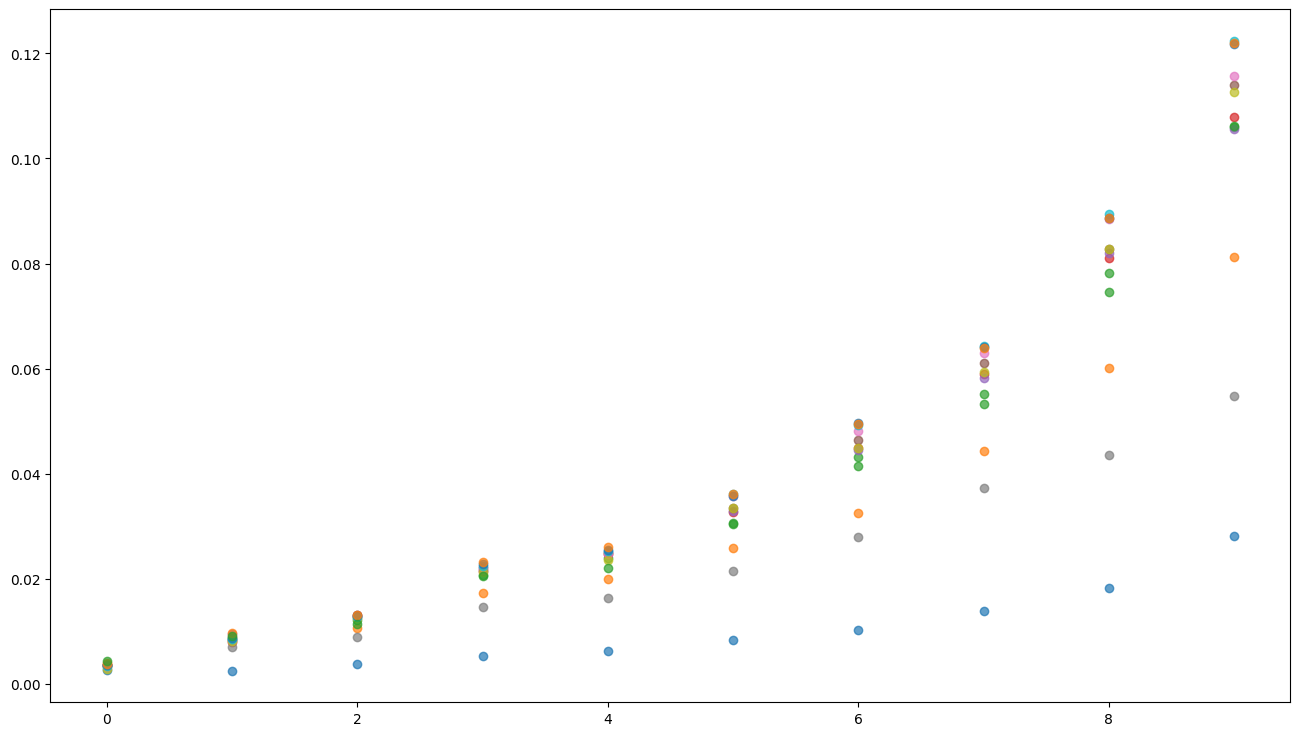

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have the following data structure
# recommender_object_dict = {'Recommender1': recommender1, 'Recommender2': recommender2, ...}
# MAP_recommender_per_group = {'Recommender1': [0.8, 0.7, 0.6, ...], 'Recommender2': [0.9, 0.8, 0.7, ...], ...}

# Your original code
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label, alpha=0.7)

# Modifications for a better plot
plt.title('Mean Average Precision (MAP) Across User Groups')
plt.xlabel('User Group')
plt.ylabel('MAP')

# Use a line plot for better trend visualization
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.plot(np.arange(0, len(results)), results, marker='o', linestyle='-', alpha=0.7)
    
    # Annotate the lines with the names of the recommender systems
    last_value = results[-1]
    plt.text(len(results)-1, last_value, label, ha='left', va='center', fontsize=8)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis ticks to integers from 0 to 4
plt.xticks(np.arange(0, len(results)))

# Set x-axis limits to 0 and 4
plt.xlim(0, len(results))

plt.show()

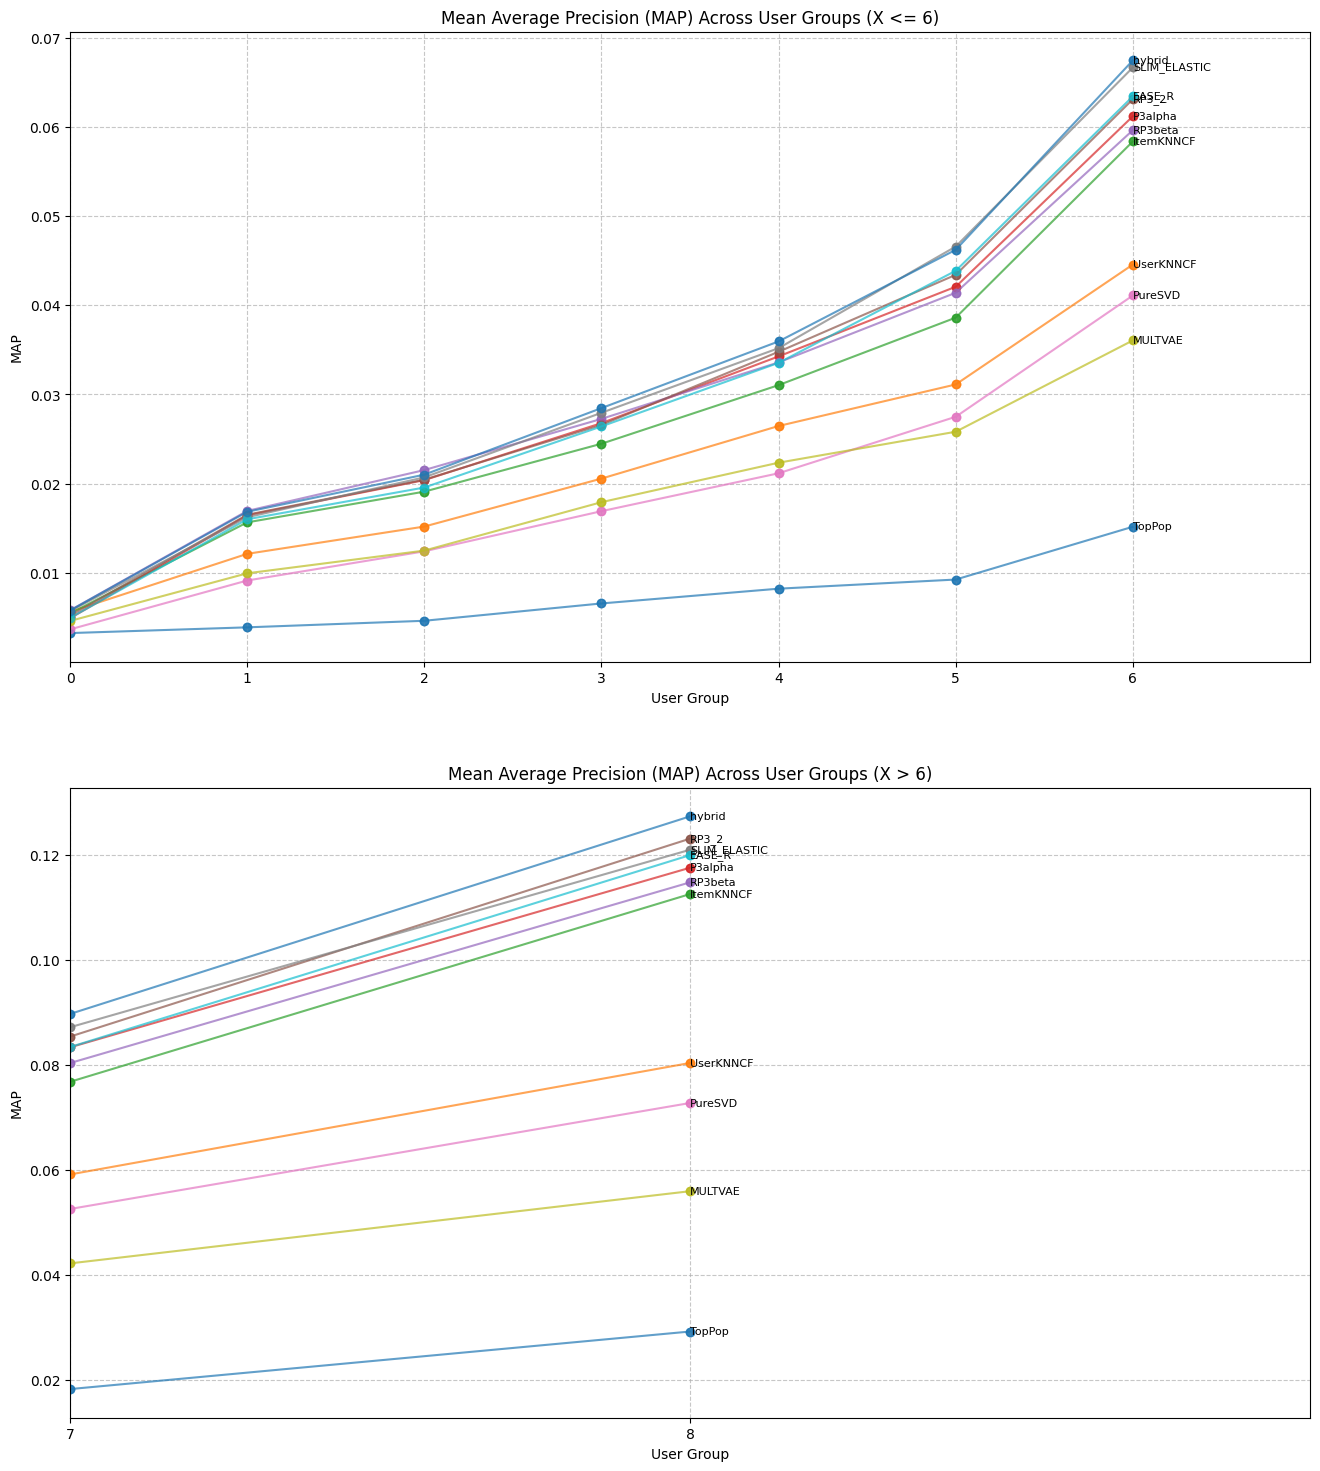

In [39]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, figsize=(16, 18))

# Plot for X values <= 6
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    results_cutoff = results[:7]  # Get values for X <= 6
    axs[0].scatter(x=np.arange(0, len(results_cutoff)), y=results_cutoff, label=label, alpha=0.7)
    axs[0].plot(np.arange(0, len(results_cutoff)), results_cutoff, marker='o', linestyle='-', alpha=0.7)
    last_value = results_cutoff[-1]
    axs[0].text(len(results_cutoff)-1, last_value, label, ha='left', va='center', fontsize=8)

axs[0].set_title('Mean Average Precision (MAP) Across User Groups (X <= 6)')
axs[0].set_xlabel('User Group')
axs[0].set_ylabel('MAP')
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].set_xticks(np.arange(0, len(results_cutoff)))
axs[0].set_xlim(0, len(results_cutoff))

# Plot for X values > 6
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    results_cutoff = results[7:]  # Get values for X > 6
    axs[1].scatter(x=np.arange(7, len(results)), y=results_cutoff, label=label, alpha=0.7)
    axs[1].plot(np.arange(7, len(results)), results_cutoff, marker='o', linestyle='-', alpha=0.7)
    last_value = results_cutoff[-1]
    axs[1].text(len(results)-1, last_value, label, ha='left', va='center', fontsize=8)

axs[1].set_title('Mean Average Precision (MAP) Across User Groups (X > 6)')
axs[1].set_xlabel('User Group')
axs[1].set_ylabel('MAP')
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].set_xticks(np.arange(7, len(results)))
axs[1].set_xlim(7, len(results))

plt.show()

In [52]:
import pandas as pd
print(pd.DataFrame(MAP_recommender_per_group))

     TopPop  UserKNNCF  ItemKNNCF   P3alpha   RP3_old       RP3  SLIM_ELASTIC  \
0  0.002694   0.003985   0.003393  0.003638  0.003692  0.003655      0.003324   
1  0.002524   0.008983   0.008627  0.007979  0.009431  0.008405      0.008284   
2  0.003793   0.010584   0.012129  0.012895  0.013118  0.013105      0.012744   
3  0.005287   0.017397   0.020734  0.021526  0.021771  0.022083      0.022180   
4  0.006326   0.019947   0.024042  0.024730  0.025065  0.024856      0.024650   
5  0.008475   0.025831   0.030664  0.032689  0.033003  0.033522      0.035851   
6  0.010284   0.032525   0.043179  0.044865  0.044510  0.046516      0.048072   
7  0.013881   0.044284   0.055146  0.059006  0.058232  0.061017      0.062907   
8  0.018290   0.060074   0.078292  0.081149  0.081951  0.082848      0.088478   
9  0.028251   0.081183   0.105932  0.107827  0.105685  0.113932      0.115634   

    MULTVAE    EASE_R  hybrid_new    hybrid    superH     KNN_H    KNN_H2  \
0  0.003643  0.002877    0.0034

In [53]:
pd.DataFrame(MAP_recommender_per_group)

,TopPop,UserKNNCF,ItemKNNCF,P3alpha,RP3_old,RP3,SLIM_ELASTIC,MULTVAE,EASE_R,hybrid_new,hybrid,superH,KNN_H,KNN_H2,superH2,KNN_H3
0,0.002694,0.003985,0.003393,0.003638,0.003692,0.003655,0.003324,0.003643,0.002877,0.003495,0.003530,0.003811,0.004364,0.004255,0.003794,0.002994
1,0.002524,0.008983,0.008627,0.007979,0.009431,0.008405,0.008284,0.007143,0.008264,0.008622,0.008703,0.009776,0.009101,0.009581,0.009252,0.007682
2,0.003793,0.010584,0.012129,0.012895,0.013118,0.013105,0.012744,0.008868,0.012495,0.012845,0.012949,0.013106,0.011412,0.011705,0.013149,0.012217
3,0.005287,0.017397,0.020734,0.021526,0.021771,0.022083,0.022180,0.014647,0.021356,0.022546,0.022808,0.023168,0.020538,0.020960,0.023121,0.019382
4,0.006326,0.019947,0.024042,0.024730,0.025065,0.024856,0.024650,0.016466,0.023598,0.025294,0.025512,0.025989,0.022000,0.022954,0.025587,0.021725
5,0.008475,0.025831,0.030664,0.032689,0.033003,0.033522,0.035851,0.021482,0.033547,0.036232,0.035828,0.036200,0.030469,0.030800,0.036314,0.030656
6,0.010284,0.032525,0.043179,0.044865,0.044510,0.046516,0.048072,0.028012,0.044987,0.049294,0.049582,0.049407,0.041563,0.042745,0.049522,0.039298
7,0.013881,0.044284,0.055146,0.059006,0.058232,0.061017,0.062907,0.037352,0.059397,0.064246,0.064170,0.063849,0.053196,0.053958,0.064014,0.051420
8,0.018290,0.060074,0.078292,0.081149,0.081951,0.082848,0.088478,0.043657,0.082732,0.089523,0.088720,0.088695,0.074524,0.077136,0.088960,0.069404
9,0.028251,0.081183,0.105932,0.107827,0.105685,0.113932,0.115634,0.054717,0.112606,0.122390,0.121721,0.121947,0.106225,0.106750,0.122236,0.084000


In [8]:
df = pd.DataFrame(MAP_recommender_per_group)
# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Sort the row in descending order and get the column labels
    sorted_row = row.sort_values(ascending=False)
    
    # Get the column label of the max value in the row
    max_column = sorted_row.index[0]
    # Get the max value in the row
    max_value = sorted_row.iloc[0]
    
    # Get the column label of the second max value in the row
    second_max_column = sorted_row.index[1]
    # Get the second max value in the row
    second_max_value = sorted_row.iloc[1]
    
    print(f"Row {index}: Max value is {max_value} at {max_column}, Second max value is {second_max_value} at {second_max_column}")

Row 0: Max value is 0.004804415995862026 at MULTVAE, Second max value is 0.003490770374680761 at UserKNNCF
Row 1: Max value is 0.008711256321666413 at ItemKNNCF, Second max value is 0.00791572780531771 at hybrid
Row 2: Max value is 0.014943772702393384 at RP3beta, Second max value is 0.014650942926804989 at hybrid
Row 3: Max value is 0.017573660322475478 at hybrid, Second max value is 0.017053085583891254 at EASE_R
Row 4: Max value is 0.020584693521014278 at RP3beta, Second max value is 0.020397012578616355 at P3alpha
Row 5: Max value is 0.03324602718874874 at hybrid, Second max value is 0.03269384402243993 at SLIM_ELASTIC
Row 6: Max value is 0.07157302192964039 at hybrid, Second max value is 0.07049769149416939 at SLIM_ELASTIC
Row 7: Max value is 0.1035645584676592 at hybrid, Second max value is 0.10150527049751862 at SLIM_ELASTIC
Row 8: Max value is 0.1340992179184599 at hybrid, Second max value is 0.12791620389652458 at SLIM_ELASTIC
Row 9: Max value is 0.1588233458177278 at hybrid, 

In [49]:
#                         0, 1, 2, 3, 4,  5,  6,   7,   8,    9
#profile_length_cutoffs = [2, 4, 6, 8, 25, 50, 80, 100, 250, 1500]
df = pd.DataFrame(MAP_recommender_per_group)
for index, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    max_value = sorted_row.iloc[0]
    max_index = sorted_row.index[0]
    second_max_value = sorted_row.iloc[1]
    second_max_index = sorted_row.index[1]

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if index == 0:
        users_in_group_flag = np.logical_and(profile_length > 0, profile_length < profile_length_cutoffs[index])
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[index - 1], profile_length < profile_length_cutoffs[index])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]

    # Calculate the minimum and maximum profile lengths for the users in the group
    min_profile_length = profile_length[users_in_group_flag].min()
    max_profile_length = profile_length[users_in_group_flag].max()

    # Calculate the number of users in the group
    num_users_in_group = len(users_in_group)

    print(f"Row {index}: Max value is {max_value} at {max_index}, Second max value is {second_max_value} at {second_max_index}, Min profile length is {min_profile_length}, Max profile length is {max_profile_length}, Number of users in group is {num_users_in_group}, diff with slim is {max_value - df['SLIM_ELASTIC'][index]}, improvement: {(max_value - df['SLIM_ELASTIC'][index])*num_users_in_group}")

Row 0: Max value is 0.004363642170483217 at KNN_H, Second max value is 0.0042552138226182494 at KNN_H2, Min profile length is 1, Max profile length is 1, Number of users in group is 1008, diff with slim is 0.0010398102903133085, improvement: 1.048128772635815
Row 1: Max value is 0.00977642581743528 at superH, Second max value is 0.00958064193079966 at KNN_H2, Min profile length is 2, Max profile length is 2, Number of users in group is 738, diff with slim is 0.001492038455760852, improvement: 1.1011243803515087
Row 2: Max value is 0.013148859882362413 at superH2, Second max value is 0.013117516719039551 at RP3_old, Min profile length is 3, Max profile length is 5, Number of users in group is 1574, diff with slim is 0.0004052856337120308, improvement: 0.6379195874627365
Row 3: Max value is 0.02316765712227631 at superH, Second max value is 0.023120771269069553 at superH2, Min profile length is 6, Max profile length is 9, Number of users in group is 1492, diff with slim is 0.000987786524

In [31]:
# Create an empty DataFrame with the columns you want
df_print = pd.DataFrame(columns=['Row', 'Max Value', 'Max Index', 'Second Max Value', 'Second Max Index', 'Min Profile Length', 'Max Profile Length', 'Number of Users in Group', 'Diff with SLIM', 'Improvement'])

for index, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    max_value = sorted_row.iloc[0]
    max_index = sorted_row.index[0]
    second_max_value = sorted_row.iloc[1]
    second_max_index = sorted_row.index[1]

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if index == 0:
        users_in_group_flag = np.logical_and(profile_length > 0, profile_length < profile_length_cutoffs[index])
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[index - 1], profile_length < profile_length_cutoffs[index])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]

    # Calculate the minimum and maximum profile lengths for the users in the group
    min_profile_length = profile_length[users_in_group_flag].min()
    max_profile_length = profile_length[users_in_group_flag].max()

    # Calculate the number of users in the group
    num_users_in_group = len(users_in_group)

    # Calculate the difference with SLIM and the improvement
    diff_with_slim = max_value - df['SLIM_ELASTIC'][index]
    improvement = diff_with_slim * num_users_in_group

    # Add the values to the DataFrame
    df_print = df_print.append({
        'Row': index,
        'Max Value': max_value,
        'Max Index': max_index,
        'Second Max Value': second_max_value,
        'Second Max Index': second_max_index,
        'Min Profile Length': min_profile_length,
        'Max Profile Length': max_profile_length,
        'Number of Users in Group': num_users_in_group,
        'Diff with SLIM': diff_with_slim,
        'Improvement': improvement
    }, ignore_index=True)

# Print the DataFrame
df_print

,Row,Max Value,Max Index,Second Max Value,Second Max Index,Min Profile Length,Max Profile Length,Number of Users in Group,Diff with SLIM,Improvement
0,0,0.002899,TopPop,0.002782,ItemKNNCF,1,1,1038,0.000137,0.141860
1,1,0.010353,UserKNNCF,0.010125,RP3beta,2,2,723,0.001569,1.134091
2,2,0.012208,ItemKNNCF,0.011519,RP3beta,3,3,611,0.001020,0.623346
3,3,0.015080,RP3beta,0.015035,SLIM_ELASTIC,4,4,481,0.000045,0.021841
4,4,0.016718,RP3beta,0.015783,ItemKNNCF,5,5,467,0.001657,0.773672
5,5,0.019064,ItemKNNCF,0.018986,SLIM_ELASTIC,6,6,443,0.000078,0.034658
6,6,0.021862,P3alpha,0.021470,RP3beta,7,7,364,0.000629,0.228877
7,7,0.026343,SLIM_ELASTIC,0.024240,RP3beta,8,8,353,0.000000,0.000000
8,8,0.024286,ItemKNNCF,0.023981,P3alpha,9,9,344,0.001282,0.440980
9,9,0.026790,SLIM_ELASTIC,0.024519,RP3beta,10,10,305,0.000000,0.000000


In [12]:
import pandas as pd
import numpy as np

def load_csv_files(file_paths):
    """Load multiple CSV files into a list of dataframes, skipping the first column."""
    return [pd.read_csv(fp).iloc[:, 1:] for fp in file_paths]

def check_structure(dataframes):
    """Check if all dataframes have the same structure."""
    return all(df.shape == dataframes[0].shape and all(df.columns == dataframes[0].columns) for df in dataframes)

def average_scores(dataframes):
    """Calculate the average score for each recommender across all dataframes."""
    return sum(dataframes) / len(dataframes)

# Paths to your CSV files
file_paths = [
    'result_1.csv',
    'result_2.csv',
    'result_3.csv',
    'result_4.csv',
    'result_5.csv',
    'result_6.csv',
    'result_7.csv',
    'result_8.csv',
    'result_9.csv',
    'result_10.csv',
    'result_11.csv',
    # 'result_12.csv',
    # 'result_13.csv',
    # 'result_14.csv',
    # 'result_15.csv',
    # 'result_16.csv',
    # 'result_17.csv',
    # 'result_18.csv',
    # 'result_19.csv',
    # 'result_20.csv',
    # 'result_21.csv',
    # 'result_22.csv',
    # 'result_23.csv',
    # 'result_24.csv',
    # 'result_25.csv',
    # 'result_26.csv',
    # 'result_27.csv',
    # 'result_28.csv',
    # 'result_29.csv',
    # 'result_30.csv',
    # 'result_31.csv',
    # 'result_32.csv',
    # 'result_33.csv',
    # 'result_34.csv',
    # 'result_35.csv',
    # 'result_36.csv',
    # 'result_37.csv',
    # 'result_38.csv',
    # 'result_39.csv',
    # 'result_40.csv',
    # 'result_41.csv',
]

# Load the CSV files
dataframes = load_csv_files(file_paths)

# Check if all CSV files have the same structure
if check_structure(dataframes):
    # Calculate the average
    avg_df = average_scores(dataframes)
    print(avg_df)
else:
    print("CSV files do not have the same structure.")


     TopPop  UserKNNCF  ItemKNNCF   P3alpha   RP3beta   PureSVD  SLIM_ELASTIC  \
0  0.003083   0.003543   0.002983  0.002885  0.003103  0.002412      0.003023   
1  0.003310   0.009390   0.009450  0.009687  0.010313  0.007082      0.009846   
2  0.003538   0.010438   0.012021  0.012150  0.012699  0.007664      0.012371   
3  0.003791   0.012330   0.014727  0.015079  0.015655  0.009353      0.015170   
4  0.004486   0.015122   0.019717  0.020018  0.020579  0.011939      0.020826   
5  0.007687   0.024146   0.028947  0.030643  0.030593  0.019914      0.032387   
6  0.015160   0.048499   0.060908  0.064576  0.063565  0.042724      0.070497   
7  0.027485   0.073199   0.091002  0.095361  0.094422  0.065065      0.107778   
8  0.028939   0.085034   0.116024  0.120429  0.117632  0.077025      0.126579   
9  0.042612   0.104175   0.155814  0.160164  0.155820  0.082987      0.143549   

     hybrid  
0  0.003158  
1  0.010146  
2  0.012734  
3  0.015721  
4  0.021294  
5  0.032429  
6  0.06973

In [13]:
avg_df

,TopPop,UserKNNCF,ItemKNNCF,P3alpha,RP3beta,PureSVD,SLIM_ELASTIC,hybrid
0,0.003083,0.003543,0.002983,0.002885,0.003103,0.002412,0.003023,0.003158
1,0.003310,0.009390,0.009450,0.009687,0.010313,0.007082,0.009846,0.010146
2,0.003538,0.010438,0.012021,0.012150,0.012699,0.007664,0.012371,0.012734
3,0.003791,0.012330,0.014727,0.015079,0.015655,0.009353,0.015170,0.015721
4,0.004486,0.015122,0.019717,0.020018,0.020579,0.011939,0.020826,0.021294
5,0.007687,0.024146,0.028947,0.030643,0.030593,0.019914,0.032387,0.032429
6,0.015160,0.048499,0.060908,0.064576,0.063565,0.042724,0.070497,0.069735
7,0.027485,0.073199,0.091002,0.095361,0.094422,0.065065,0.107778,0.105800
8,0.028939,0.085034,0.116024,0.120429,0.117632,0.077025,0.126579,0.130056
9,0.042612,0.104175,0.155814,0.160164,0.155820,0.082987,0.143549,0.165175


In [16]:
#                         0, 1, 2, 3, 4,  5,  6,   7,   8,    9
#profile_length_cutoffs = [2, 4, 6, 8, 25, 50, 80, 100, 250, 1500]
df = pd.DataFrame(avg_df)
for index, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    max_value = sorted_row.iloc[0]
    max_index = sorted_row.index[0]
    second_max_value = sorted_row.iloc[1]
    second_max_index = sorted_row.index[1]

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if index == 0:
        users_in_group_flag = np.logical_and(profile_length > 0, profile_length < profile_length_cutoffs[index])
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[index - 1], profile_length < profile_length_cutoffs[index])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]
    
    # Calculate the minimum and maximum profile lengths for the users in the group
    min_profile_length = profile_length[users_in_group_flag].min()
    max_profile_length = profile_length[users_in_group_flag].max()

    # Calculate the number of users in the group
    num_users_in_group = len(users_in_group)

    print(f"Row {index}: Max value is {max_value} at {max_index}, Second max value is {second_max_value} at {second_max_index}, Min profile length is {min_profile_length}, Max profile length is {max_profile_length}, Number of users in group is {num_users_in_group}, diff with slim is {max_value - df['SLIM_ELASTIC'][index]}, improvement: {(max_value - df['SLIM_ELASTIC'][index])*num_users_in_group}")

Row 0: Max value is 0.0035434061535169546 at UserKNNCF, Second max value is 0.003158382356194518 at hybrid, Min profile length is 1, Max profile length is 1, Number of users in group is 1026, diff with slim is 0.0005202196148054086, improvement: 0.5337453247903492
Row 1: Max value is 0.010312554901606198 at RP3beta, Second max value is 0.010146400775302301 at hybrid, Min profile length is 2, Max profile length is 2, Number of users in group is 738, diff with slim is 0.00046695489172934347, improvement: 0.3446127100962555
Row 2: Max value is 0.012734452193956346 at hybrid, Second max value is 0.01269871528694958 at RP3beta, Min profile length is 3, Max profile length is 3, Number of users in group is 615, diff with slim is 0.0003632350680307806, improvement: 0.22338956683893008
Row 3: Max value is 0.015720515025641927 at hybrid, Second max value is 0.015655200674204894 at RP3beta, Min profile length is 4, Max profile length is 5, Number of users in group is 972, diff with slim is 0.0005

In [17]:
# Load the target users test file into a DataFrame
target_users_test_df = pd.read_csv('data_target_users_test.csv')

# Convert the user ids in the DataFrame to a set for faster lookup
target_users_test_set = set(target_users_test_df['user_id'])

# Iterate over the rows in the DataFrame
for index, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    max_value = sorted_row.iloc[0]
    max_index = sorted_row.index[0]
    second_max_value = sorted_row.iloc[1]
    second_max_index = sorted_row.index[1]

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if index == 0:
        users_in_group_flag = np.logical_and(profile_length > 0, profile_length < profile_length_cutoffs[index])
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[index - 1], profile_length < profile_length_cutoffs[index])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]
    
    # Calculate the minimum and maximum profile lengths for the users in the group
    min_profile_length = profile_length[users_in_group_flag].min()
    max_profile_length = profile_length[users_in_group_flag].max()

    # Calculate the number of users in the group
    num_users_in_group = len(users_in_group)

    # Calculate the number of users in the group that are also in the target users test set
    num_users_in_test_group = sum(user in target_users_test_set for user in users_in_group)

    print(f"Row {index}: Max value is {max_value} at {max_index}, Second max value is {second_max_value} at {second_max_index}, Min profile length is {min_profile_length}, Max profile length is {max_profile_length}, Number of users in group is {num_users_in_group}, Number of users in test group is {num_users_in_test_group}, diff with slim is {max_value - df['SLIM_ELASTIC'][index]}, improvement: {(max_value - df['SLIM_ELASTIC'][index])*num_users_in_group}")

Row 0: Max value is 0.0035434061535169546 at UserKNNCF, Second max value is 0.003158382356194518 at hybrid, Min profile length is 1, Max profile length is 1, Number of users in group is 1026, Number of users in test group is 862, diff with slim is 0.0005202196148054086, improvement: 0.5337453247903492
Row 1: Max value is 0.010312554901606198 at RP3beta, Second max value is 0.010146400775302301 at hybrid, Min profile length is 2, Max profile length is 2, Number of users in group is 738, Number of users in test group is 610, diff with slim is 0.00046695489172934347, improvement: 0.3446127100962555
Row 2: Max value is 0.012734452193956346 at hybrid, Second max value is 0.01269871528694958 at RP3beta, Min profile length is 3, Max profile length is 3, Number of users in group is 615, Number of users in test group is 515, diff with slim is 0.0003632350680307806, improvement: 0.22338956683893008
Row 3: Max value is 0.015720515025641927 at hybrid, Second max value is 0.015655200674204894 at RP